# Data Science Workshop Project

###  Dean Ayalon, Yair Hadas, Eran Horowitz 

# Getting to know the data

### Importing necessary libraries and files:

In [1]:
from utils.plot_utils import *
from utils.table_utils import return_unique_values_of_column_from_table, filter_table_by_unique_ids, get_ads_per_feat
from paths import *

import numpy as np
import pandas as pd
import zipfile as zp
import os.path
import sklearn.linear_model
import sklearn.ensemble
import sklearn.preprocessing
import sklearn.grid_search
from utils.analysis_utils import *
pd.options.mode.chained_assignment = None # Eliminates some false warnings

# Imports for drawing plots
%matplotlib
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

Using matplotlib backend: Qt5Agg


## Introducing the Data

### Let's take a peek at our data:

In [2]:
# Importing all tables (notice that all the globals are in paths.py):
z_tables = zp.ZipFile(os.path.join('tables','tables.zip'))
clicks = pd.read_csv(z_tables.open(CLICKS))
doc_categories = pd.read_csv(z_tables.open(DOC_CATEGORIES))
doc_entities = pd.read_csv(z_tables.open(DOC_ENTITIES))
doc_meta = pd.read_csv(z_tables.open(DOC_META))
doc_topics = pd.read_csv(z_tables.open(DOC_TOPICS))
# The warning comes from events table. we will see later it is important.
events = pd.read_csv(z_tables.open(EVENTS))
# display_geo is a table we prepared ahead from events.csv. You can see how it's done in geo_split.py
promoted = pd.read_csv(z_tables.open(PROMOTED_CONTENT))
display_geo = pd.read_csv(z_tables.open(DISPLAY_GEO))
z_tables.close()

z_dataset_p1 = zp.ZipFile(os.path.join('tables','dataset_p1.zip'))
z_dataset_p2 = zp.ZipFile(os.path.join('tables','dataset_p2.zip'))
dataset = pd.concat([pd.read_csv(z_dataset_p1.open('final_dataset_p1.csv')),
                     pd.read_csv(z_dataset_p2.open('final_dataset_p2.csv'))],ignore_index=True)
z_dataset_p1.close()
z_dataset_p2.close()

z_page_views_p1 = zp.ZipFile(os.path.join('tables','page_views_p1.zip'))
z_page_views_p2 = zp.ZipFile(os.path.join('tables','page_views_p2.zip'))
page_views = pd.concat([pd.read_csv(z_page_views_p1.open('sample_page_views_p1.csv')),
                     pd.read_csv(z_page_views_p2.open('sample_page_views_p2.csv'))],ignore_index=True)
z_page_views_p1.close()
z_page_views_p2.close()


In [3]:
clicks.head()

,display_id,ad_id,clicked
0,7,105766,1
1,7,215967,0
2,7,300808,0
3,106,14120,0
4,106,39897,0


In [4]:
doc_categories.head()

,document_id,category_id,confidence_level
0,1615583,1305,0.920000
1,1615583,1806,0.070000
2,1615460,1613,0.540646
3,1615460,1603,0.041136
4,1614225,1608,0.920000


In [5]:
doc_entities.head()

,document_id,entity_id,confidence_level
0,1615583,9a934d9b311bf64b8648056653a70e61,0.293982
1,1615460,89109265cb36c5ca14a9e99c6c7d1918,0.373328
2,1614225,670847189b721233d9e3765b862b8b5d,0.259860
3,1614225,f7ebe65fd9b4034847ff8ec4dd9d62f3,0.222156
4,1614225,9f12cea57fd2f5f8f5ae9c92147c2bdd,0.218127


In [6]:
doc_meta.head()

,document_id,source_id,publisher_id,publish_time
0,1615583,1.0,603.0,2016-06-07 00:00:00
1,1615460,1.0,603.0,2016-06-20 00:00:00
2,1614225,1.0,603.0,2016-06-09 00:00:00
3,1614048,1.0,603.0,2016-06-05 12:00:00
4,1610319,1.0,603.0,2016-06-14 00:00:00


In [7]:
doc_topics.head()

,document_id,topic_id,confidence_level
0,1615583,89,0.316306
1,1615583,198,0.015722
2,1615460,260,0.097964
3,1615460,26,0.014551
4,1614225,113,0.197576


In [8]:
events.head()

,display_id,uuid,document_id,timestamp,platform,geo_location
0,7,2cc3f6457d16da,1149661,602,2,US>MT>762
1,106,36f0d66b583e3d,1788531,7873,2,US>NM>790
2,107,20b0db64279f06,1108855,7999,2,US
3,146,cc848dea324952,1320212,11062,1,CA>NS
4,170,b2778a037a571e,1773530,12840,1,US>TN>640


In [9]:
page_views.head()

,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,5fe4adf60dce62,7012,42055742,1,CA>ON,1
1,6bb8e6792f606d,7012,19864732,3,AU>02,2
2,bfd545d2d62900,7012,10865117,1,AU>02,2
3,e1defdc3f432cd,7012,23082700,1,VN>44,2
4,cf566213938074,7012,59916025,1,CA>ON,2


In [10]:
promoted.head()

,ad_id,document_id,campaign_id,advertiser_id
0,2,471467,2,7
1,3,7692,3,7
2,4,471471,2,7
3,7,12808,1,7
4,8,471477,2,7


In [11]:
display_geo.head()

,country,state,DMA,display_id
0,US,MT,762.0,7
1,US,NM,790.0,106
2,US,NaN,NaN,107
3,CA,NS,NaN,146
4,US,TN,640.0,170


In [12]:
# This is the complete dataset. It was made in advance and is presented here for convenience.
# Yet, along the notebook we recreate it as part of the work flow.
# More information about Doc_id_x and Doc_id_y - in the documentation.
dataset.head()

,display_id,ad_id,clicked,document_id_x,click_tstamp,is_morning,is_noon,is_afternoon,is_evening,is_night,...,document_id_y,clicks_appearances_ratio,country_is_US,country_is_GB,country_is_CA,country_is_AU,topic_sim,entities_sim,categories_sim,topic_popularity_conf
0,7,105766,1,1149661,1465876800,0.0,0.0,0.0,1.0,0.0,...,1151028,0.070000,1,0,0,0,0.008674,0.0,0.000000,3.117834
1,7,215967,0,1149661,1465876800,0.0,0.0,0.0,1.0,0.0,...,1445187,0.108911,1,0,0,0,0.000000,0.0,0.000000,7.203284
2,7,300808,0,1149661,1465876800,0.0,0.0,0.0,1.0,0.0,...,1701364,0.000000,1,0,0,0,0.002026,0.0,0.601944,1.457441
3,106,14120,0,1788531,1465876807,0.0,0.0,0.0,1.0,0.0,...,700394,0.224138,1,0,0,0,0.000000,0.0,0.000000,6.581212
4,106,39897,0,1788531,1465876807,0.0,0.0,0.0,1.0,0.0,...,900154,0.224090,1,0,0,0,0.000000,0.0,0.000000,2.536574


### Preparing the main dataset

In [13]:
# This dataset will be built along the run of the notebook, for demonstration
# and "proof of concept" reasons.
b_dataset = dataset[["display_id","ad_id","clicked","document_id_x","document_id_y",'click_tstamp']]
b_dataset.head()

,display_id,ad_id,clicked,document_id_x,document_id_y,click_tstamp
0,7,105766,1,1149661,1151028,1465876800
1,7,215967,0,1149661,1445187,1465876800
2,7,300808,0,1149661,1701364,1465876800
3,106,14120,0,1788531,700394,1465876807
4,106,39897,0,1788531,900154,1465876807


# Data Preparation

One of the main challenges we faced was deciding how to integrate the many tables contained in the data set to one comprehensive table on which we can run our models. It took us a while to understand the connections between them, and the meanings of the various features contained in each of them. Null values were an issue, but eventually we managed to construct features only based on columns which had no or very few null values. Over the next section, detailing feature extraction, we will show whre this was relevant, and how we dealt with it. 

# Feature Extraction

## Similarities - Do users tend to click on similiar documents?

Our first idea was very intuitive. We were wondering if users tend to click on ads that are closely related to the topic of the article they just read. Later we expanded this idea for entities and categories as well.

In [16]:
# Multi-purpose function used to extract similarity metrics for document topics, entities and categories
def find_similarity(table, doc_out, doc_in, field):
    # Extracting all data relevant to doc_out
    out_frame = table[table.document_id == doc_out]
    out_items = np.array(out_frame[field])
    out_conf = np.array(out_frame.confidence_level)

    # Extracting all data relevant to doc_in
    in_frame = table[table.document_id == doc_in]
    in_items = np.array(in_frame[field])
    in_conf = np.array(in_frame.confidence_level)

    # Computing requested similarity by multiplying conf levels of shared topics/entities/categories
    similarity = 0
    for out_index in range(len(out_items)):
        item = out_items[out_index]
        if item in in_items:
            in_index = np.argwhere(in_items == item)[0][0]
            s1 = out_conf[out_index]
            s2 = in_conf[in_index]
            similarity += s1*s2
    return similarity

WARNING! Running this code takes about 7 hours.

In [17]:
compute_similarities = False

if compute_similarities:
    n = len(b_dataset)
    topic_similarities = np.zeros(n)
    entities_similarities = np.zeros(n)
    categories_similarities = np.zeros(n)
    counter = 0

    # Runs on each row in the data set and calculates it's similarity
    for row in b_dataset.itertuples():
        if not counter % n/100:
            print("Adding similarity features: passed through " + (str(round(counter * 100 / n))) + "% of rows")
        doc_out = row.document_id_x
        doc_in = row.document_id_y

        topic_similarity = find_similarity(doc_topics, doc_out, doc_in, "topic_id")
        topic_similarities[counter] = topic_similarity

        categories_similarity = find_similarity(doc_categories, doc_out, doc_in, "category_id")
        categories_similarities[counter] = categories_similarity

        entities_similarity = find_similarity(doc_entities, doc_out, doc_in, "entity_id")
        entities_similarities[counter] = entities_similarity

        counter += 1

    # Creating the final table
    similarities["topic_sim"] = topic_similarities
    similarities["entities_sim"] = entities_similarities
    similarities["categories_sim"] = categories_similarities

else:
    similarities = dataset[['topic_sim','entities_sim','categories_sim']]
    
similarities.head()

,topic_sim,entities_sim,categories_sim
0,0.008674,0.0,0.000000
1,0.000000,0.0,0.000000
2,0.002026,0.0,0.601944
3,0.000000,0.0,0.000000
4,0.000000,0.0,0.000000


In [16]:
b_dataset = pd.concat((b_dataset, similarities), axis=1)
b_dataset.head()

,display_id,ad_id,clicked,document_id_x,document_id_y,click_tstamp,topic_sim,entities_sim,categories_sim
0,7,105766,1,1149661,1151028,1465876800,0.008674,0.0,0.000000
1,7,215967,0,1149661,1445187,1465876800,0.000000,0.0,0.000000
2,7,300808,0,1149661,1701364,1465876800,0.002026,0.0,0.601944
3,106,14120,0,1788531,700394,1465876807,0.000000,0.0,0.000000
4,106,39897,0,1788531,900154,1465876807,0.000000,0.0,0.000000


The following bar charts presents the relevance of each element similarity to most of the data, and how effective it is when it exists.

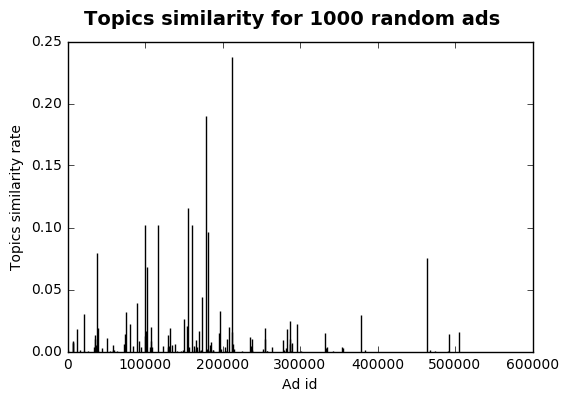

In [18]:
create_similarity_histograms(dataset,1000,"topic_sim","Topics")

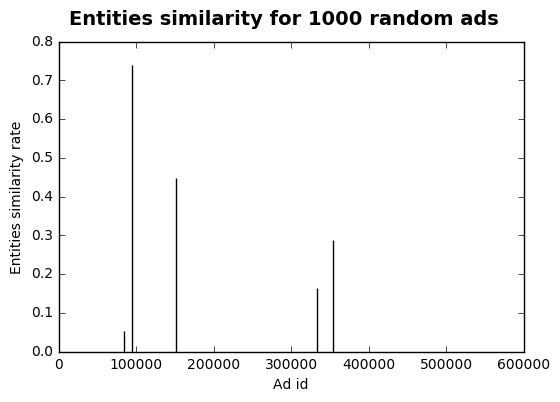

In [19]:
create_similarity_histograms(dataset,1000,"entities_sim","Entities")

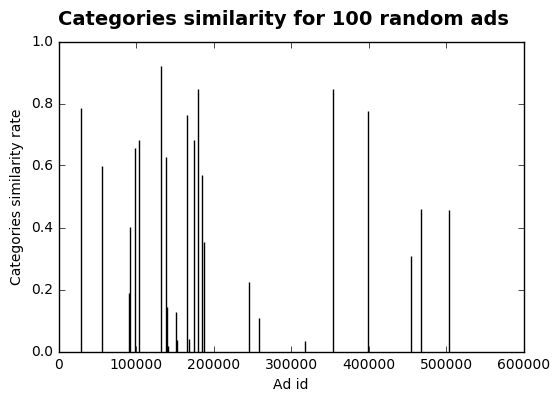

In [20]:
create_similarity_histograms(dataset,100,"categories_sim","Categories")

## First Attempt: Logistic Regression with Similarity Features

Now, after having the similarity features, we ran our first modeling attempt, using Logistic Regression.
But first, let's see how we evaluate our models.

### Evaluating our Models

Just like in the competition, we use the MAP@12 metric to evaluate our models, as well as ordinary 0/1 loss. Further details can be found in the documentation. 

In [21]:
def MAP12_Accuracy(test_data):
    print("Now calculating MAP@12 accuracy, should take about 5 minutes")
    test_displays = test_data.display_id.unique()
    acc_counter = 0
    counter = 0
    for display in test_displays:
        display_df = test_data[test_data.display_id == display]
        true_ad = np.array(display_df[display_df.clicked == 1][["ad_id"]])[0][0]
        
        # Sorting ads according to predicted click probability
        display_probs = np.array(display_df.probability_of_click)
        ads = np.array(display_df.ad_id)
        idx_sorted = display_probs.argsort()[::-1]
        ads_sorted = ads[idx_sorted]
        
        # Finding index of true ad in the array
        idx_true = np.argwhere(ads_sorted == true_ad)[0][0] + 1
        acc_counter += 1 / idx_true
        counter += 1

    accuracy_map = acc_counter / len(test_displays)
    return accuracy_map

Running the model:

In [22]:
def one_model_analysis(dataset,features,features_to_scale,model,models_name):
    for feature in features_to_scale:
        dataset[feature] = dataset[feature].astype(float)
        dataset[feature] = sklearn.preprocessing.scale(dataset[feature])

    # Splitting to train (80%) and test (20%) sets
    train_data, test_data = split_to_test_and_train(dataset)

    train_features_list = [train_data[feature] for feature in features]
    test_features_list = [test_data[feature] for feature in features]

    # Extracting X and y vectors for train and test
    train_points, train_labels = prepare_dataset_for_model(train_features_list, train_data.clicked)
    test_points, test_labels = prepare_dataset_for_model(test_features_list, test_data.clicked)

    model.fit(train_points, train_labels)

    display_probs = model.predict_proba(test_points)[:, 1]
    test_data["probability_of_click"] = display_probs

    # Evaluating the model using 0/1 loss
    zero_one_accuracy = accuracy_zero_one_loss(test_data)
    print("0/1 Accuracy for "+models_name+" Model: " + str(zero_one_accuracy))

    # Evaluating the model using MAP@12 metric
    map12_accuracy = MAP12_Accuracy(test_data)
    print("MAP@12 Accuracy for "+models_name+" Model: " + str(map12_accuracy))

Let's see how far that got us:

In [23]:
# Running Logistic Regression on the similarity features:
model = sklearn.linear_model.LogisticRegression()
features = ["topic_sim", "entities_sim", "categories_sim"]
one_model_analysis(dataset, features, features, model,"Logistic Regression")

0/1 Accuracy for Logistic Regression Model: 0.260644708249
Now calculating MAP@12 accuracy, should take about 5 minutes
MAP@12 Accuracy for Logistic Regression Model: 0.501692210549


This was obviously far from good, as even simple single-feature models could acheive much better results (see documentation and appendix). At this point we came to the realisation we needed a lot more features - so we spent a sizeable amount of time thinking about and generating all the features mentioned above.

## The Search Continues - Extracting More Features

### Click Time

It's reasonable to assume that people tend to click different ads when surfing at different times of day, so we wanted to factor the time each click happened into the model. The click timestamps provided were all UTC, so they didn't account for timezone differences between countries. Fortunately for us, some countries appear in the data a lot more than others. Let's take a look:

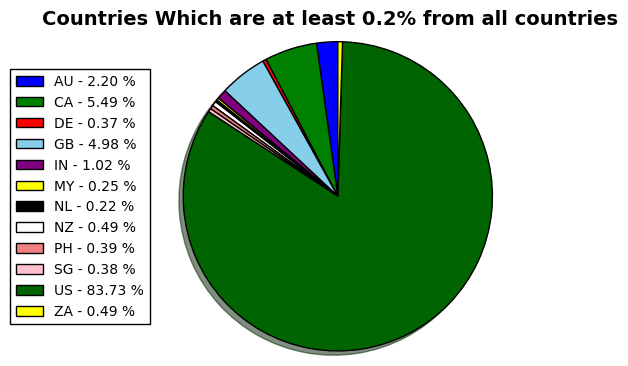

In [24]:
create_countries_pie_chart(display_geo,500)

Four countries stand out: United States, Canada, Great Britain and Australia. Let's see just how much of the data originates from one of these countries:

In [25]:
display_geo.head()
countries_with_counts = np.unique(display_geo.country.astype(str), return_counts=True)

countries = countries_with_counts[0]
counts = countries_with_counts[1]
srt_idx = counts.argsort()[::-1]

countries = countries[srt_idx]
counts = counts[srt_idx]

top_4 = counts[:4]
float(sum(top_4)) / sum(counts)

0.92623302141927844

Over 92% of the data is from one of those four countries, so we thought it's reasonable to apply timezone corrections only for events which originated from one of them (further details can be found in the documentation.

Finally, in order to input this factor into the model, we chose to "bin" each click event to one of 5 bins, based on its (timezone corrected) timestamp (more details in documentation):

In [26]:
working_table = b_dataset.groupby("display_id").first().reset_index()

relevant_countries = ["CA", "US", "AU", "GB"]

click_timestamps = working_table["click_tstamp"]
geolocations = events["geo_location"].apply(str) #events contains only relevant displays

# Timezone correction for the 4 most common countries in the data
localized_hours = []
for i in range(len(geolocations)):
    country = geolocations[i][:2]
    timezone_correction = 0
    if country in relevant_countries:
        if country == "GB":
            timezone_correction = 1
        elif country == "CA" or country == "US":
            timezone_correction = -5.5
        elif country == "AU":
            timezone_correction = 10.5
    timestamp = click_timestamps[i]
    as_datetime64 = np.datetime64(int(timestamp), 's')
    as_datetime = pd.to_datetime(as_datetime64)
    corrected_hour = as_datetime.hour + timezone_correction
    if corrected_hour > 23.5:
        corrected_hour -= 24
    elif corrected_hour < 0:
        corrected_hour += 24
    localized_hours.append(corrected_hour)


# Creating boolean vectors for "binning" the hours
localized_hours = pd.Series(localized_hours)
is_morning = np.zeros(shape=len(working_table))
is_noon = np.zeros(shape=len(working_table))
is_afternoon = np.zeros(shape=len(working_table))
is_evening = np.zeros(shape=len(working_table))
is_night = np.zeros(shape=len(working_table))

for i in range(len(localized_hours)):
    if 7 <= localized_hours[i] < 12:
        is_morning[i] = 1
    elif 12 <= localized_hours[i] < 16:
        is_noon[i] = 1
    elif 16 <= localized_hours[i] < 20:
        is_afternoon[i] = 1
    elif 20 <= localized_hours[i] < 24:
        is_evening[i] = 1
    elif 0 <= localized_hours[i] < 7:
        is_night[i] = 1

bin_time = pd.DataFrame()
bin_time["display_id"] = working_table["display_id"]
bin_time["is_morning"] = is_morning
bin_time["is_noon"] = is_noon
bin_time["is_afternoon"] = is_afternoon
bin_time["is_evening"] = is_evening
bin_time["is_night"] = is_night

bin_time.head()

,display_id,is_morning,is_noon,is_afternoon,is_evening,is_night
0,7,0.0,0.0,0.0,1.0,0.0
1,106,0.0,0.0,0.0,1.0,0.0
2,107,0.0,0.0,0.0,1.0,0.0
3,146,0.0,0.0,0.0,1.0,0.0
4,170,0.0,0.0,0.0,1.0,0.0


In [27]:
#adding the new feature to the dataset:
b_dataset = b_dataset.merge(bin_time, on="display_id", how="left")
b_dataset.head()

,display_id,ad_id,clicked,document_id_x,document_id_y,click_tstamp,is_morning,is_noon,is_afternoon,is_evening,is_night
0,7,105766,1,1149661,1151028,1465876800,0.0,0.0,0.0,1.0,0.0
1,7,215967,0,1149661,1445187,1465876800,0.0,0.0,0.0,1.0,0.0
2,7,300808,0,1149661,1701364,1465876800,0.0,0.0,0.0,1.0,0.0
3,106,14120,0,1788531,700394,1465876807,0.0,0.0,0.0,1.0,0.0
4,106,39897,0,1788531,900154,1465876807,0.0,0.0,0.0,1.0,0.0


Let's see how the clicks spread across those bins:

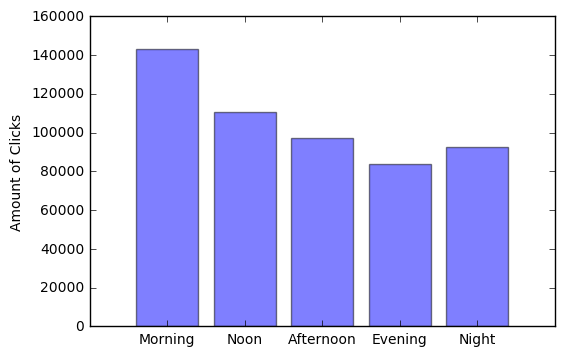

In [28]:
morning_clicks = sum(bin_time.is_morning)
noon_clicks = sum(bin_time.is_noon)
afternoon_clicks = sum(bin_time.is_afternoon)
evening_clicks = sum(bin_time.is_evening)
night_clicks = sum(bin_time.is_night)

times = ["Morning", "Noon", "Afternoon", "Evening", "Night"]
click_amounts = [morning_clicks, noon_clicks, afternoon_clicks, evening_clicks, night_clicks]

plt.bar(range(5), click_amounts, align="center", alpha=0.5)
plt.xticks(range(5), times)
plt.ylabel("Amount of Clicks")
plt.show()

### Platforms

In order to take into account the platforms, we decided to inser them as binary features. we had to deal with some cleaning with that feature. details in the documentation.

In [29]:
# Extracting the platform vector and creating 3 boolean vectors based on it
platforms = events["platform"]
platform_is_desktop = np.array(platforms == 1, dtype=int)
platform_is_mobile = np.array(platforms == 2, dtype=int)
platform_is_tablet = np.array(platforms == 3, dtype=int)

# Creating the result Dataframe
binary_platform_frame = pd.DataFrame()
binary_platform_frame["display_id"] = events["display_id"]
binary_platform_frame["platform_is_desktop"] = platform_is_desktop
binary_platform_frame["platform_is_mobile"] = platform_is_mobile
binary_platform_frame["platform_is_tablet"] = platform_is_tablet

#adding the feature to dataset
b_dataset = b_dataset.merge(binary_platform_frame, on="display_id", how="left")

binary_platform_frame.head()

,display_id,platform_is_desktop,platform_is_mobile,platform_is_tablet
0,7,0,1,0
1,106,0,1,0
2,107,0,1,0
3,146,1,0,0
4,170,1,0,0


In [30]:
b_dataset.head()

,display_id,ad_id,clicked,document_id_x,document_id_y,click_tstamp,is_morning,is_noon,is_afternoon,is_evening,is_night,platform_is_desktop,platform_is_mobile,platform_is_tablet
0,7,105766,1,1149661,1151028,1465876800,0.0,0.0,0.0,1.0,0.0,0,1,0
1,7,215967,0,1149661,1445187,1465876800,0.0,0.0,0.0,1.0,0.0,0,1,0
2,7,300808,0,1149661,1701364,1465876800,0.0,0.0,0.0,1.0,0.0,0,1,0
3,106,14120,0,1788531,700394,1465876807,0.0,0.0,0.0,1.0,0.0,0,1,0
4,106,39897,0,1788531,900154,1465876807,0.0,0.0,0.0,1.0,0.0,0,1,0


The following bar chart represents how the clicks devides between each platform:

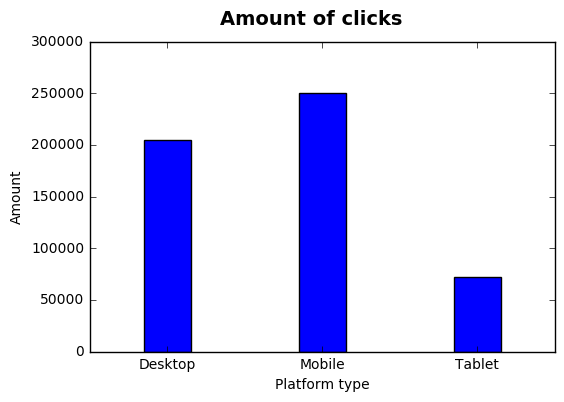

In [31]:
plot_platform_histogram(binary_platform_frame)

### Weekend Clicks

We expected the clicking trends to be different over the weekends - the data includes two of them: 18-19.6 and 25-26.6.
In order to include this in the model, we created a binary vector based on the click times. This time we dind't correct for timezone, mainly because when we did the results were actually worse.

In [32]:
# Extracting relevant columns from main table
table = b_dataset.groupby("display_id").first().reset_index()[["display_id", "click_tstamp"]]
timestamps = table["click_tstamp"]
# Initializing empty is_weekend array
is_weekend_boolean = np.zeros(shape=len(timestamps))

for i in range(len(timestamps)):
    # Format conversions to allow use of is_busday function
    as_datetime64 = np.datetime64(int(timestamps[i]), 's')
    as_datetime = pd.to_datetime(as_datetime64)

    # Using the is_busday to return an is_weekend boolean - True for Saturday and Sunday, False otherwise
    boolean = np.is_busday(as_datetime, weekmask='0000011')
    is_weekend_boolean[i] = boolean

# Creating result Dataframe with two columns - display_id and is_weekend
is_weekend = pd.DataFrame()
is_weekend["display_id"] = table["display_id"]
is_weekend["is_weekend"] = is_weekend_boolean

is_weekend.head()

,display_id,is_weekend
0,7,0.0
1,106,0.0
2,107,0.0
3,146,0.0
4,170,0.0


In [33]:
b_dataset = b_dataset.merge(is_weekend, on='display_id',how='left')
b_dataset.head()

,display_id,ad_id,clicked,document_id_x,document_id_y,click_tstamp,is_morning,is_noon,is_afternoon,is_evening,is_night,platform_is_desktop,platform_is_mobile,platform_is_tablet,is_weekend
0,7,105766,1,1149661,1151028,1465876800,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0
1,7,215967,0,1149661,1445187,1465876800,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0
2,7,300808,0,1149661,1701364,1465876800,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0
3,106,14120,0,1788531,700394,1465876807,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0
4,106,39897,0,1788531,900154,1465876807,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0


### Ads per Display

Outbrain's displays are not of uniform size. Some can be comprised of only 2 ads, while others can contain as many as 12 ads. We expected this to have an effect, as it indirectly measures the host site's popularity / resources - bigger and wealthier sites will probably feature bigger displays, as it makes sense to use them as an advertising platform. 

In [34]:
# Extracting the display_id's vector from main table
displays_and_ads = b_dataset[["display_id"]]

# Counting how many times every display_id appears in the vector - this equals the ad count per each display
ad_counts = displays_and_ads.groupby("display_id").display_id.agg("count")
ad_counts = pd.Series(ad_counts.as_matrix())

# Extracting vector of unique displays
displays = displays_and_ads["display_id"].unique()

# Creating result Dataframe, contaning the ad count for each display_id
# (has only display_id and ad_count columns)
disp_size_count = pd.DataFrame()
disp_size_count["display_id"] = displays
disp_size_count["ad_count_per_display"] = ad_counts.astype(int)

disp_size_count.head()

,display_id,ad_count_per_display
0,7,3
1,106,8
2,107,4
3,146,6
4,170,6


In [35]:
b_dataset = b_dataset.merge(disp_size_count, on='display_id',how='left')
b_dataset.head()

,display_id,ad_id,clicked,document_id_x,document_id_y,click_tstamp,is_morning,is_noon,is_afternoon,is_evening,is_night,platform_is_desktop,platform_is_mobile,platform_is_tablet,is_weekend,ad_count_per_display
0,7,105766,1,1149661,1151028,1465876800,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,3
1,7,215967,0,1149661,1445187,1465876800,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,3
2,7,300808,0,1149661,1701364,1465876800,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,3
3,106,14120,0,1788531,700394,1465876807,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,8
4,106,39897,0,1788531,900154,1465876807,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,8


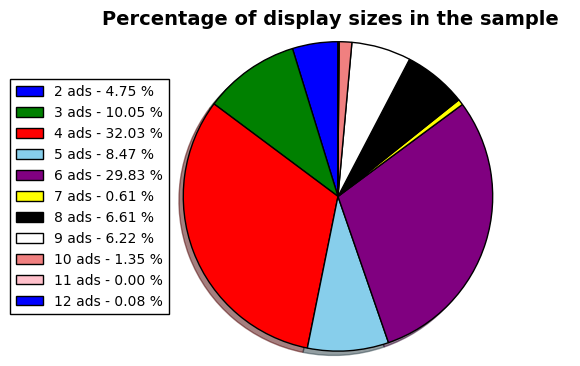

In [36]:
create_disp_number_piechart(b_dataset)

### Ads Per Advertiser and Ads Per Campaign

#### Ads per advertiser

This was another indirect way of comparing different advertisers. Bigger / wealthier advertisers will tend to advertise more, and their ads are probably inherently more attractive than ads from smaller advertisers.

In [37]:
# Loading the relevant tables
ad_advertisers = promoted[["ad_id", "advertiser_id"]]
# Counting the number of times an advertiser appeared:
ads_per_advertiser = promoted.groupby(["advertiser_id"], as_index=False).agg({"ad_id": np.count_nonzero})\
    .rename(index=str, columns={"ad_id": "ads_per_advertiser"})
#advertiser_freq_per_ad = ad_advertisers.merge(ad_per_advertiser, on="advertiser_id")
#advertiser_freq_per_ad.drop(['advertiser_id'], axis=1, inplace=True)

ads_per_advertiser.head()

,advertiser_id,ads_per_advertiser
0,3,10
1,4,59
2,5,33
3,6,5
4,7,42


#### Ads per campaign

This allowed us to gauge whether an ad was a part of a big campaign or not. We assumed that ads from big campaigns are more attractive, and will therefore have a higher chance of being clicked on.

In [38]:
# Loading the relevant tables
ad_campaigns = promoted[["ad_id", "campaign_id"]]
# Counting the number of times an advertiser appeared:
ad_per_campaign = ad_campaigns.groupby(["campaign_id"], as_index=False).agg({"ad_id": np.count_nonzero})\
    .rename(index=str, columns={"ad_id": "ads_per_campaign"})
#campaign_freq_per_ad = ad_campaigns.merge(ad_per_campaign, on="campaign_id", copy=False)
#campaign_freq_per_ad.drop(['campaign_id'], axis=1, inplace=True)

ad_per_campaign.head()

,campaign_id,ads_per_campaign
0,1,11
1,2,28
2,3,2
3,4,118
4,5,5


#### Bar charts - Advertisers / Campaigns Popularity

The following bar charts represent the amount of ads and clicks of 50 random advertisers/campaigns, in order to demonstrate the popularity effect.

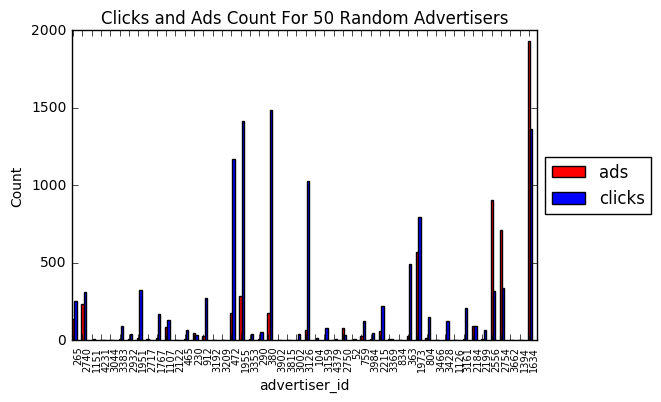

In [40]:
create_advertiser_or_campaign_pop_histogram(dataset,promoted,"advertiser_id",
                                            "Clicks and Ads Count For 50 Random Advertisers")

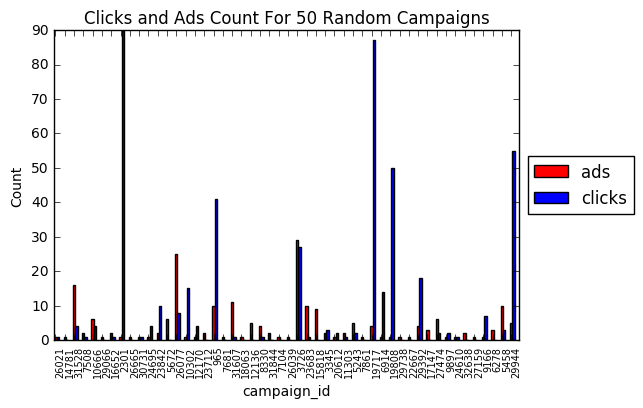

In [41]:
create_advertiser_or_campaign_pop_histogram(dataset,promoted,"campaign_id",
                                            "Clicks and Ads Count For 50 Random Campaigns")

In [42]:
#adding the feature to dataset:
ad_and_advertiser_and_campaign_freq = promoted.merge(ads_per_advertiser, on='advertiser_id')\
                                                .merge(ad_per_campaign, on='campaign_id')
ad_and_advertiser_and_campaign_freq.drop(['document_id','campaign_id','advertiser_id'],axis=1,inplace=True)

b_dataset = b_dataset.merge(ad_and_advertiser_and_campaign_freq, on='ad_id',how='left')
b_dataset.head()

,display_id,ad_id,clicked,document_id_x,document_id_y,click_tstamp,is_morning,is_noon,is_afternoon,is_evening,is_night,platform_is_desktop,platform_is_mobile,platform_is_tablet,is_weekend,ad_count_per_display,ads_per_advertiser,ads_per_campaign
0,7,105766,1,1149661,1151028,1465876800,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,3,297,37
1,7,215967,0,1149661,1445187,1465876800,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,3,240,8
2,7,300808,0,1149661,1701364,1465876800,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,3,875,13
3,106,14120,0,1788531,700394,1465876807,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,8,61,1
4,106,39897,0,1788531,900154,1465876807,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,8,274,10


Remark: we are aware that the advertiser and campaign count is different then in the made in advance dataset. that's because in that dataset we calculated the counts from the whole table, and here for the "proof of concept" we calculate them from a filtered table.

### CTR - Click Through Ratio

The most basic and common method of evaluating an ad's attractiveness - the number of times it was clicked divided by the number of times it appeared in a given timeframe.

In [43]:
# Slicing only necessary columns
table = dataset[["ad_id", "clicked"]]
# Calculating clicks/appearances ratio
click_ratio_frame = table.groupby("ad_id").clicked.agg(["mean"]).reset_index()

click_ratio_frame.rename(index=str, columns={"mean": "clicks_appearances_ratio"}, inplace=True)

click_ratio_frame.head(10)

,ad_id,clicks_appearances_ratio
0,2,0.000000
1,3,0.000000
2,4,0.000000
3,7,0.281818
4,8,0.000000
5,10,0.000000
6,12,0.000000
7,13,0.000000
8,21,0.000000
9,27,0.000000


The following histograms represent the amount of time an ad appeared and the amount of clicks it got. It can be seen that the behavior of both histograms is very similiar, which implies a strong relation between those features.  

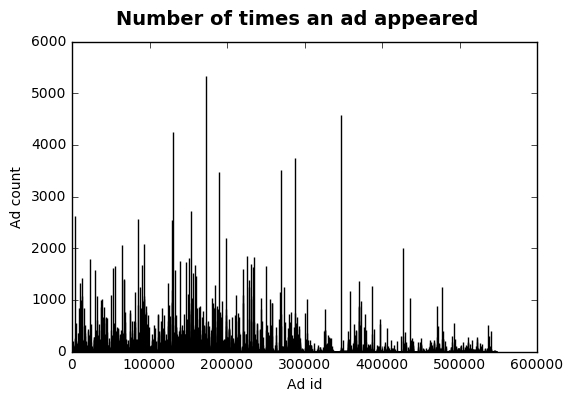

In [44]:
# Adding ad appearance histogram
create_ads_clicks_histogram(dataset,create_ad_appearance = True)

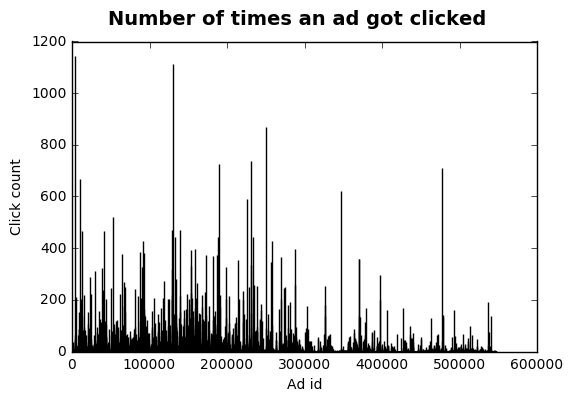

In [45]:
# Adding ad clicks histogram
create_ads_clicks_histogram(dataset)

In [46]:
b_dataset = b_dataset.merge(click_ratio_frame, on='ad_id', how='left')
b_dataset.head()

,display_id,ad_id,clicked,document_id_x,document_id_y,click_tstamp,is_morning,is_noon,is_afternoon,is_evening,is_night,platform_is_desktop,platform_is_mobile,platform_is_tablet,is_weekend,ad_count_per_display,ads_per_advertiser,ads_per_campaign,clicks_appearances_ratio
0,7,105766,1,1149661,1151028,1465876800,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,3,297,37,0.070000
1,7,215967,0,1149661,1445187,1465876800,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,3,240,8,0.108911
2,7,300808,0,1149661,1701364,1465876800,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,3,875,13,0.000000
3,106,14120,0,1788531,700394,1465876807,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,8,61,1,0.224138
4,106,39897,0,1788531,900154,1465876807,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,8,274,10,0.224090


# Analysis - Trying to Predict!

### Second Attempt: More Features, Gradient Boosting and Random Forest

We then wanted to check whether logistic regression's performance has improved, and also check whether there are better models we can use. A lot of other teams used gradient boosting and random forests, so we decided to check them as well and compare them to logistic regression.

In [47]:
features = ["topic_sim", "entities_sim", "categories_sim",
            "is_morning", "is_noon", "is_afternoon", "is_evening", "is_night",
            "is_weekend", "platform_is_mobile", "platform_is_desktop", "platform_is_tablet",
            "clicks_appearances_ratio", "ad_count_per_display", "ads_per_advertiser",
            "ads_per_campaign"]

features_to_scale = ["topic_sim", "entities_sim", "categories_sim",
                     "clicks_appearances_ratio", "ad_count_per_display",
                     "ads_per_advertiser", "ads_per_campaign"]

for feature in features_to_scale:
    dataset[feature] = dataset[feature].astype(float)  # Avoids scaling conversion warnings for ints
    dataset[feature] = sklearn.preprocessing.scale(dataset[feature])
    
train_data, test_data = split_to_test_and_train(dataset)
    
train_features_list = [train_data[feature] for feature in features]
test_features_list = [test_data[feature] for feature in features]

# Extracting X and y vectors for train and test
train_points, train_labels = prepare_dataset_for_model(train_features_list, train_data.clicked)
test_points, test_labels = prepare_dataset_for_model(test_features_list, test_data.clicked)
    
models = [sklearn.linear_model.LogisticRegression(),
         sklearn.ensemble.GradientBoostingClassifier(),
         sklearn.ensemble.RandomForestClassifier()]

model_names = ["Logistic Regression", "Gradient Boosting", "Random Forest"]

map_12_accuracies = np.zeros(shape=3)
zero_one_accuracies = np.zeros(shape=3)

for i in range(len(models)):
    model = models[i]
    print("Now checking " + model_names[i])
    model.fit(train_points, train_labels)
    display_probs = model.predict_proba(test_points)[:, 1]
    test_data["probability_of_click"] = display_probs
    zero_one_accuracies[i] = accuracy_zero_one_loss(test_data)
    map_12_accuracies[i] = MAP12_Accuracy(test_data)
    

Now checking Logistic Regression
Now calculating MAP@12 accuracy, should take about 5 minutes
Now checking Gradient Boosting
Now calculating MAP@12 accuracy, should take about 5 minutes
Now checking Random Forest
Now calculating MAP@12 accuracy, should take about 5 minutes


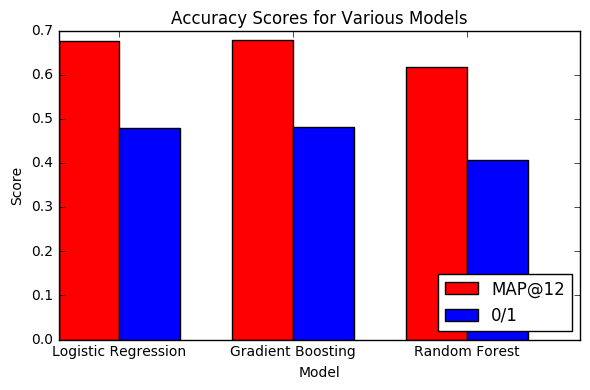

                 Model  MAP@12 Accuracy  0/1 Accuracy
0  Logistic Regression         0.677195      0.480381
1    Gradient Boosting         0.678031      0.481244
2        Random Forest         0.618160      0.406050


In [48]:
# Plotting the scores
fig = plt.figure()
plt.bar(range(3), map_12_accuracies, 0.35, color='r', label="MAP@12")
plt.bar(np.array(range(3)) + 0.35, zero_one_accuracies, 0.35, color='b', label="0/1")
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Accuracy Scores for Various Models')
plt.xticks(np.array(range(3)) + 0.35, ("Logistic Regression", "Gradient Boosting", "Random Forest"))
plt.legend(loc = 4)
plt.tight_layout()
plt.show()
    
acc_frame = pd.DataFrame()
acc_frame["Model"] = model_names
acc_frame["MAP@12 Accuracy"] = map_12_accuracies
acc_frame["0/1 Accuracy"] = zero_one_accuracies

print(acc_frame)

Now we needed to decide which model to work with.
Clearly, random forest is inferior to the other two models, so we decided not to pursue it further.  
Let's see how far we can improve each of the remaining models using cross validation to tune their parameters.

In [49]:
# Using CV to tune LR's C parameter and penalty type
model = sklearn.linear_model.LogisticRegression(verbose=True)
parameters = {"C": [10**-5, 1, 10, 100, 1000], "penalty": ["l1","l2"]}
cv = sklearn.grid_search.GridSearchCV(model, parameters, verbose=True)
cv.fit(train_points,train_labels)

base_param_grid = cv.grid_scores_
C_values = np.array([10**-5, 1, 10, 100, 1000])
validation_scores = np.zeros(shape=len(base_param_grid))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.8min finished


[LibLinear]

C:\Users\Dean\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


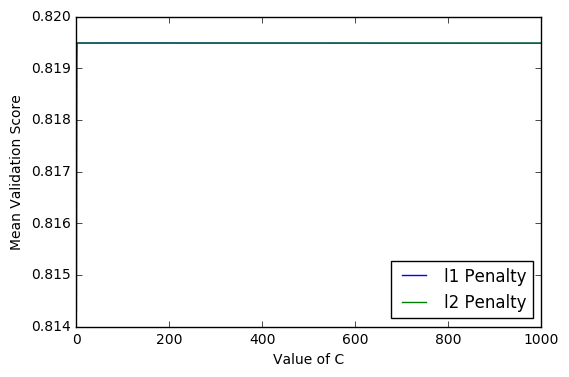

In [50]:
# Plotting the scores
l1_accuracies = []
l2_accuracies = []
for i in range(len(base_param_grid)):
    penalty = base_param_grid[i].parameters['penalty']
    accuracy = base_param_grid[i].mean_validation_score
    if penalty == 'l1':
        l1_accuracies.append(accuracy)
    else:
        l2_accuracies.append(accuracy)
        
fig = plt.figure()
plt.plot(C_values, l1_accuracies, label="l1 Penalty")
plt.plot(C_values, l2_accuracies, label="l2 Penalty")
plt.xlabel("Value of C")
plt.ylabel("Mean Validation Score")
plt.legend(loc = 4)
fig.show()

As we can see, tuning LR's parameters hardly makes any difference regarding accuracy. Let's measure the performance of LR with the best values for the parameters:

In [51]:
model = cv.best_estimator_
model.fit(train_points, train_labels)
display_probs = model.predict_proba(test_points)[:, 1]
test_data["probability_of_click"] = display_probs
zero_one_accuracy = accuracy_zero_one_loss(test_data)
map_12_accuracy = MAP12_Accuracy(test_data)

print("0/1 Accuracy for best LR model is " + str(zero_one_accuracy))
print("MAP@12 Accuracy for best LR model is " + str(map_12_accuracy))

[LibLinear]Now calculating MAP@12 accuracy, should take about 5 minutes
0/1 Accuracy for best LR model is 0.480390203168
MAP@12 Accuracy for best LR model is 0.677195340927


So even with optimized parameters, LR still acheives less than the Gradient Boosting model.
Let's now try optimizing GB:

In [52]:
skip_computation = False

if not skip_computation:
    model = sklearn.ensemble.GradientBoostingClassifier()
    parameters = {"max_depth": [2, 3, 4, 5, 6]}
    cv = sklearn.grid_search.GridSearchCV(model, parameters, verbose=True, n_jobs=2)
    cv.fit(train_points,train_labels)
    model = cv.best_estimator_
    
else:
    model = sklearn.ensemble.GradientBoostingClassifier(max_depth=6)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed: 78.2min finished


C:\Users\Dean\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


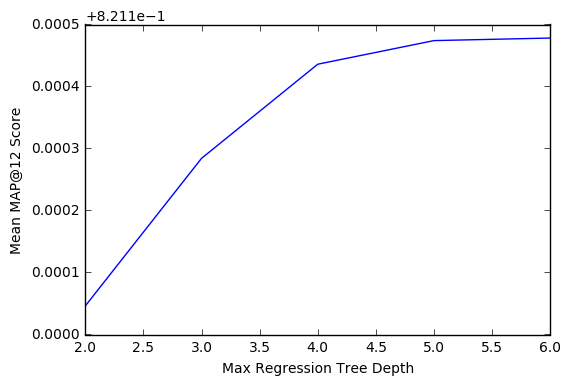

In [53]:
# Plotting the scores (Impossible if skipped computation in previous cell)
base_param_grid = cv.grid_scores_
max_depth_values = np.array([2, 3, 4, 5, 6])
validation_scores = np.zeros(shape=len(base_param_grid))
for i in range(5):
    validation_scores[i] = base_param_grid[i].mean_validation_score
    
fig = plt.figure()
plt.plot(max_depth_values, validation_scores)
plt.xlabel("Max Regression Tree Depth")
plt.ylabel("Mean MAP@12 Score")
fig.show()

It seems enlarging the maximum depth for the regression trees does make a difference. We chose to stick to a max depth of 6 - increasing it further will probably improve the results slightly, but at the expense of much longer running time.

Now let's perform the final test for our model. Coincidentally, the number of displays in the data is divisible by 7, so we can perform 7-fold cross validation to make final evaluation of our model. Please note - running the next cell of code takes about 3.5 hours.

In [56]:
displays = dataset.display_id.unique()
np.random.RandomState(0).shuffle(displays)

# Performing 7-fold CV - each fold takes about 45 minutes
zero_one_accuracies = np.zeros(shape=7)
map_12_accuracies = np.zeros(shape=7)

for i in range(7):
    print("Now working on fold number " + str(i+1))
    test_displays = displays[i*75326:(i+1)*75326]
    if i == 0:
        train_displays = displays[75326:]
    elif i == 6:
        train_displays = displays[:6*75326]
    else:
        train_displays = np.concatenate((displays[:i*75326], displays[(i+1)*75326:]))

    train_df = dataset[dataset.display_id.isin(train_displays)]
    test_df = dataset[dataset.display_id.isin(test_displays)]

    train_features_list = [train_df[feature] for feature in features]
    test_features_list = [test_df[feature] for feature in features]

    # Extracting X and y vectors for train and test
    train_points, train_labels = prepare_dataset_for_model(train_features_list, train_df.clicked)
    test_points, test_labels = prepare_dataset_for_model(test_features_list, test_df.clicked)

    model.fit(train_points, train_labels)

    display_probs = model.predict_proba(test_points)[:, 1]
    test_df["probability_of_click"] = display_probs  # Error generated at this line can be ignored

    # Evaluating the model using 0/1 loss
    zero_one_accuracy = accuracy_zero_one_loss(test_df)
    zero_one_accuracies[i] = zero_one_accuracy
    print("0/1 Accuracy for Gradient Boosting Algorithm: " + str(zero_one_accuracy))

    # Evaluating the model using MAP@12 metric
    map12_accuracy = MAP12_Accuracy(test_df)
    map_12_accuracies[i] = map12_accuracy
    print("MAP@12 Accuracy for Gradient Boosting Algorithm: " + str(map12_accuracy))

print("Mean 0-1 Accuracy: " + str(zero_one_accuracies.mean()))
print("Mean Map@12 Accuracy: " + str(map_12_accuracies.mean()))

Now working on fold number 1
0/1 Accuracy for Gradient Boosting Algorithm: 0.484985264052
Now calculating MAP@12 accuracy, should take about 5 minutes
MAP@12 Accuracy for Gradient Boosting Algorithm: 0.680500652307
Now working on fold number 2
0/1 Accuracy for Gradient Boosting Algorithm: 0.484600270823
Now calculating MAP@12 accuracy, should take about 5 minutes
MAP@12 Accuracy for Gradient Boosting Algorithm: 0.680289537724
Now working on fold number 3
0/1 Accuracy for Gradient Boosting Algorithm: 0.483246156706
Now calculating MAP@12 accuracy, should take about 5 minutes
MAP@12 Accuracy for Gradient Boosting Algorithm: 0.679319926424
Now working on fold number 4
0/1 Accuracy for Gradient Boosting Algorithm: 0.484958712795
Now calculating MAP@12 accuracy, should take about 5 minutes
MAP@12 Accuracy for Gradient Boosting Algorithm: 0.68049505662
Now working on fold number 5
0/1 Accuracy for Gradient Boosting Algorithm: 0.484918885909
Now calculating MAP@12 accuracy, should take about 

Final MAP@12 Score: 0.68059 (+/- 0.00149)


C:\Users\Dean\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


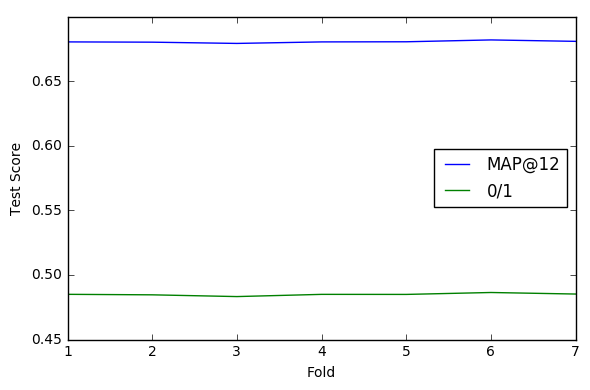

In [57]:
# Plotting the CV scores
fig = plt.figure()
plt.plot(range(1,8), map_12_accuracies, label="MAP@12")
plt.plot(range(1,8), zero_one_accuracies, label="0/1")
plt.xlabel("Fold")
plt.ylabel("Test Score")
plt.legend(loc = 7)
plt.tight_layout()
fig.show()

print("Final MAP@12 Score: %0.5f (+/- %0.5f)" % (map_12_accuracies.mean(), map_12_accuracies.std() * 2))

As we can see in the graph and in the accuracy printout, the model we managed to build is quite stable - the score hardly changes for the different folds.

Our model acheives a CV score of 0.68059. For comparison, the top team got a score of 0.70145, and the 50th best got a score of 0.67945. 

### Which features were critical?

In [58]:
sorted_idx = model.feature_importances_.argsort()
np_features = np.array(features)
np.dstack((np_features[sorted_idx], model.feature_importances_[sorted_idx]))

array([[['is_evening', '0.002543555585860264'],
        ['is_afternoon', '0.0033188521481625293'],
        ['is_morning', '0.003484306946493579'],
        ['is_noon', '0.005454903311718147'],
        ['platform_is_tablet', '0.005682644791740341'],
        ['is_night', '0.0065139553040917154'],
        ['is_weekend', '0.008939231352909714'],
        ['platform_is_desktop', '0.015592396307666744'],
        ['platform_is_mobile', '0.016476583345792745'],
        ['entities_sim', '0.049362662824821386'],
        ['ads_per_campaign', '0.07626774850444396'],
        ['ad_count_per_display', '0.08673111422353247'],
        ['topic_sim', '0.09449687477376192'],
        ['categories_sim', '0.10083856667773344'],
        ['ads_per_advertiser', '0.12848970625976955'],
        ['clicks_appearances_ratio', '0.3958068976415017']]], 
      dtype='<U32')

As expected, the clicks/appearances ratio was the most important feature. It's followed by the number of ads per advertiser, which apparently does (to a degree) serve as an indicator of ad attractiveness. The most important similarity feature turned out to be the one for categories, but topic similarity wasn't far behind. Interestingly, the time-of-day-based features turned out to be not important at all, along with the platform-based features.

# Can We Improve Even More?

## Adding New Features:

### Does the popularity of a topic effect on the click probability?

In [45]:
# Clicks per topic:

relevant_ads_and_docs = dataset[["document_id_y", "ad_id", "clicked"]]\
    .rename(index=str, columns={"document_id_y": "document_id"})

# Merge them with document_topics
relevant_ads_docs_and_topics = relevant_ads_and_docs.merge(doc_topics, on='document_id')

# Count the amount of clicks
clicks_per_topic = relevant_ads_docs_and_topics.groupby(["topic_id"], as_index=False).agg({"clicked": np.sum})\
    .rename(index=str, columns={'clicked': 'clicks_No'})

clicks_per_topic.head()
        

,topic_id,clicks_No
0,0,4763
1,1,4179
2,2,4090
3,3,1188
4,4,1124


In [46]:
# Documents per topic
# Filter from the whole docuemnt_topics table the relevant rows
relevant_docs = return_unique_values_of_column_from_table('document_id_y', b_dataset)
f_topics = doc_topics[doc_topics.document_id.isin(relevant_docs)]
# For each topic count the amount of docs which relate to it
docs_per_topic = f_topics.groupby(["topic_id"], as_index=False).agg({"document_id": np.count_nonzero})\
    .rename(index=str, columns={"document_id": "doc_No"})
    
# Now we calculate the clicks-docs ratio with regard to the confidence.
# Merge the two relations we have created previously
topic_popularity = relevant_ads_docs_and_topics.merge(clicks_per_topic, on="topic_id")\
                         .merge(docs_per_topic, on="topic_id")

topic_popularity['topic_popularity_conf'] = \
    (topic_popularity['clicks_No']*topic_popularity['confidence_level'])/topic_popularity['doc_No']

# Drop unnecessary columns and duplicate rows and sum the whole values we got for each ad (since an ad can have different topics)
topic_popularity = topic_popularity.drop_duplicates()
topic_popularity.drop(['clicked', 'document_id', 'topic_id', 'confidence_level', 'clicks_No', 'doc_No'],
                      axis=1, inplace=True)
topic_popularity = topic_popularity.groupby(["ad_id"], as_index=False).agg({"topic_popularity_conf": np.sum})

topic_popularity.head()

,ad_id,topic_popularity_conf
0,2,2.292239
1,3,2.046142
2,4,2.372946
3,7,3.222943
4,8,1.322065


### Representative bar chart:

Again we can see in a bar chart how the difference between the amount of clicks and the amount of doc a topic got shows it's popularity.

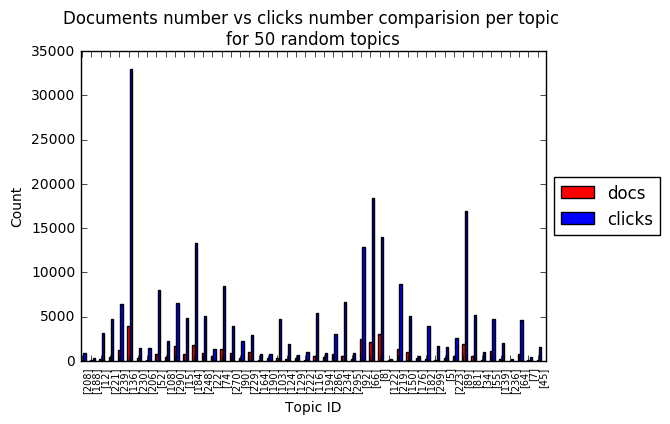

In [47]:
top_no = 50
indexes = np.random.RandomState(0).permutation(len(docs_per_topic))[:top_no]
topic_ids = np.array(docs_per_topic[["topic_id"]])[indexes]
doc_No = np.array(docs_per_topic[["doc_No"]])[indexes]
clicks = np.array(clicks_per_topic[["clicks_No"]])[indexes]

create_two_bars_histogram(top_no,doc_No,clicks,topic_ids,
                          "Documents Number Vs. Clicks Number Comparison Per Topic \n"
                          "For 50 Random Topics",
                          'Topic ID','Count','docs')

In [48]:
# Adding feature to dataset:
b_dataset = b_dataset.merge(topic_popularity, on="ad_id", how="left")

# Do we have Nan values? how much?
Nan_No = b_dataset.topic_popularity_conf.isnull().sum()
print("There are {:d} Nan values Which are {:.2f}% from the whole data"\
      .format(Nan_No,Nan_No/len(b_dataset)))

There are 27864 Nan values Which are 0.01% from the whole data


In [49]:
# Completing the missing values with the mean value:
b_dataset.topic_popularity_conf = b_dataset.topic_popularity_conf\
    .fillna(b_dataset.topic_popularity_conf.mean())

# Check that this worked
print("Now there are {:d} Nan values :)"\
      .format(b_dataset.topic_popularity_conf.isnull().sum()))


Now there are 0 Nan values :)


In [64]:
b_dataset.head()

,display_id,ad_id,clicked,document_id_x,document_id_y,click_tstamp,is_morning,is_noon,is_afternoon,is_evening,is_night,platform_is_desktop,platform_is_mobile,platform_is_tablet,is_weekend,ad_count_per_display,ads_per_advertiser,ads_per_campaign,clicks_appearances_ratio,topic_popularity_conf
0,7,105766,1,1149661,1151028,1465876800,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,3,297,37,0.070000,3.117834
1,7,215967,0,1149661,1445187,1465876800,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,3,240,8,0.108911,7.203284
2,7,300808,0,1149661,1701364,1465876800,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,3,875,13,0.000000,1.457441
3,106,14120,0,1788531,700394,1465876807,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,8,61,1,0.224138,6.581212
4,106,39897,0,1788531,900154,1465876807,0.0,0.0,0.0,1.0,0.0,0,1,0,0.0,8,274,10,0.224090,2.536574


### Let's Take The Countries Into Account Too!

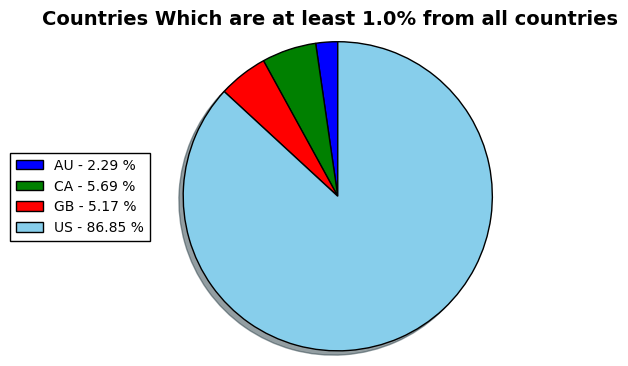

In [65]:
# A reminder that most of the events happened in 4 main countries:
create_countries_pie_chart(display_geo,100)

In [66]:
# Extracting the countries vector and creating 4 boolean vectors based on it.
countries = display_geo["country"]
country_is_US = np.array(countries == 'US', dtype=int)
country_is_GB = np.array(countries == 'GB', dtype=int)
country_is_CA = np.array(countries == 'CA', dtype=int)
country_is_AU = np.array(countries == 'AU', dtype=int)

# Creating the result Dataframe
bin_countries = pd.DataFrame()
bin_countries["display_id"] = display_geo["display_id"]
bin_countries["country_is_US"] = country_is_US
bin_countries["country_is_GB"] = country_is_GB
bin_countries["country_is_CA"] = country_is_CA
bin_countries["country_is_AU"] = country_is_AU

# Adding the feature to our dataset:
b_dataset = b_dataset.merge(bin_countries, on="display_id", how="left")
b_dataset.head()

,display_id,ad_id,clicked,document_id_x,document_id_y,click_tstamp,is_morning,is_noon,is_afternoon,is_evening,...,is_weekend,ad_count_per_display,ads_per_advertiser,ads_per_campaign,clicks_appearances_ratio,topic_popularity_conf,country_is_US,country_is_GB,country_is_CA,country_is_AU
0,7,105766,1,1149661,1151028,1465876800,0.0,0.0,0.0,1.0,...,0.0,3,297,37,0.070000,3.117834,1,0,0,0
1,7,215967,0,1149661,1445187,1465876800,0.0,0.0,0.0,1.0,...,0.0,3,240,8,0.108911,7.203284,1,0,0,0
2,7,300808,0,1149661,1701364,1465876800,0.0,0.0,0.0,1.0,...,0.0,3,875,13,0.000000,1.457441,1,0,0,0
3,106,14120,0,1788531,700394,1465876807,0.0,0.0,0.0,1.0,...,0.0,8,61,1,0.224138,6.581212,1,0,0,0
4,106,39897,0,1788531,900154,1465876807,0.0,0.0,0.0,1.0,...,0.0,8,274,10,0.224090,2.536574,1,0,0,0


# Another Prediction 

### Third Attempt: Did the Extra Features Actually Help?

In [67]:
features = ["topic_sim", "entities_sim", "categories_sim",
            "is_morning", "is_noon", "is_afternoon", "is_evening", "is_night",
            "is_weekend", "platform_is_mobile", "platform_is_desktop", "platform_is_tablet",
            "clicks_appearances_ratio", "ad_count_per_display", "ads_per_advertiser",
            "ads_per_campaign", "topic_popularity_conf", "country_is_US",
            "country_is_GB", "country_is_CA", "country_is_AU"]

features_to_scale = ["topic_sim", "entities_sim", "categories_sim",
                     "clicks_appearances_ratio", "ad_count_per_display",
                     "ads_per_advertiser", "ads_per_campaign", "topic_popularity_conf"]

model = sklearn.ensemble.GradientBoostingClassifier(max_depth=6, verbose=True)

one_model_analysis(dataset,features,features_to_scale,model,"Gradient Boosting")

      Iter       Train Loss   Remaining Time 
         1           0.9512           37.67m
         2           0.9276           36.91m
         3           0.9091           36.43m
         4           0.8940           35.64m
         5           0.8817           35.28m
         6           0.8716           34.86m
         7           0.8631           34.29m
         8           0.8559           33.89m
         9           0.8499           33.59m
        10           0.8447           33.16m
        20           0.8205           29.50m
        30           0.8144           25.64m
        40           0.8125           21.68m
        50           0.8115           17.79m
        60           0.8110           13.90m
        70           0.8105           10.24m
        80           0.8101            6.72m
        90           0.8098            3.30m
       100           0.8095            0.00s
0/1 Accuracy for Gradient Boosting Model: 0.48326548429
Now calculating MAP@12 accuracy, should tak

As we can see, the MAP@12 score acheived with the extra features isn't meaningfully different compared to the previous model.

# In conclusion

By focusing on feature engineering and model selection and optimization, we managed to construct a model on par with the top 50 models in the competition.